# CLASIFICAR ggF y VBF CON MACHINE LEARNING

## PAQUETES

In [1]:
# dataframes 
import numpy as np
import pandas as pd

# cargar archivos
import uproot
from tqdm import tqdm # sirve para ver la linea de carga al cargar los archivos
import sys
import yaml

# gráficos
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

# funcion de xgboost que clasifica
from xgboost import XGBClassifier

# graficar el arbol de desiciones del modelo, rcparams es para que se vea HD
from xgboost import plot_tree
from matplotlib.pylab import rcParams

# medir que tan bueno es el modelo
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# encontrar mejor modelo (validacion)
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score

# funciones creadas
from lectura import *
from formulas import *
from cortes import *
from graficar import *

## MACHINE LEARNING

### XGBOOST

In [2]:
def do_classification(X_train, y_train):
    # aqui se hace el machine learning, creo un modelo y lo entreno
    modelo = XGBClassifier(learning_rate=0.05,
                          max_depth=6,
                          )
    modelo.fit(X_train, y_train)
    
    return modelo

### VALIDACION

In [3]:
def find_best_model(X_train, y_train, X_test, y_test, X_val, y_val):

    # Define el modelo que deseas ajustar (por ejemplo, un clasificador RandomForest)
    modelo = XGBClassifier()

    # Define la grilla de hiperparámetros que deseas probar
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 9],
    }

    # Realiza la búsqueda en cuadrícula con validación cruzada en el conjunto de entrenamiento
    grid_search = GridSearchCV(estimator=modelo, param_grid=param_grid, scoring='accuracy', cv=5)
    grid_search.fit(X_train, y_train)

    # Obtiene el mejor modelo con los mejores hiperparámetros
    best_model = grid_search.best_estimator_

    # Evalúa el mejor modelo utilizando validación cruzada en el conjunto de entrenamiento
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
    print(f'Precisión en validación cruzada (promedio): {cv_scores.mean() * 100:.2f}%')

    # Evalúa el mejor modelo en el conjunto de validación independiente
    y_val_pred = best_model.predict(X_val)
    accuracy_val = accuracy_score(y_val, y_val_pred)
    print(f'Precisión en el conjunto de validación: {accuracy_val * 100:.2f}%')

    # Evalúa el mejor modelo en el conjunto de prueba independiente
    y_test_pred = best_model.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    print(f'Precisión en el conjunto de prueba: {accuracy_test * 100:.2f}%')

    return best_model

### METRICAS

In [4]:
# grafico las desiciones que tomo el arbol
def grafico_decisiones(modelo):
    rcParams['figure.figsize'] = 200,500
    plot_tree(modelo)
    plt.show()

def precision(modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Precisión del modelo: {accuracy * 100:.2f}%')

def confusion(modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)
    matriz = confusion_matrix(y_test, y_pred)
    return matriz
    # display_matriz = ConfusionMatrixDisplay(confusion_matrix=matriz)
    # display_matriz.plot()
    # plt.show()


#                 Predicción Positivo    Predicción Negativo
# Actual Positivo        TP                    FN
# Actual Negativo        FP                    TN
def plot_matriz(matrix, porcentaje, normalizado):
    classes = ["VBF", "ggF"]

    # normalizo los datos dependiendo si son vbf o ggf
    if normalizado == True:
        n_datos_vbf = matrix[0][0]+matrix[0][1]
        n_datos_ggf = matrix[1][0]+matrix[1][1]
        matriz_confusion = [[matrix[0][0]/n_datos_vbf,matrix[0][1]/n_datos_vbf],
                            [matrix[1][0]/n_datos_ggf,matrix[1][1]/n_datos_ggf]]
    else: 
        matriz_confusion = matrix


    # Crear una figura y un subplot
    plt.figure(figsize=(6, 6)) # para que no se vea tan grande
    plt.matshow(matriz_confusion, cmap="Blues", fignum=1)

    # Agregar etiquetas
    for i in range(2):
        for j in range(2):
            plt.text(j, i, np.format_float_scientific(matriz_confusion[i][j], precision=3), ha="center", va="center", fontsize=14, color="r")

    # Configuración de ejes y etiquetas
    plt.xticks([0, 1], classes)
    plt.yticks([0, 1], classes)
    plt.xlabel("Predicción", fontsize=12)
    plt.ylabel("Valor Real", fontsize=12)
    plt.title("Matriz de Confusión", fontsize=14)

    # Mostrar el gráfico
    plt.show()

def plot_confusion_barras(matrix):

    # normalizo los datos de vbf y ggf
    n_datos_vbf = matrix[0][0]+matrix[0][1]
    n_datos_ggf = matrix[1][0]+matrix[1][1]
    datos = [matrix[0][0]/n_datos_vbf,matrix[0][1]/n_datos_vbf,
            matrix[1][0]/n_datos_ggf,matrix[1][1]/n_datos_ggf]

    # creo un dataframe para realizar el gráfico más facilmente con seaborn
    matriz_graficar = {'valor normalizado':datos,
                       'origen real':["VBF", "VBF", "ggF", "ggF"],
                       'clasificado como':["VBF", "ggf", "VBF", "ggf"],}
    df_matriz = pd.DataFrame(matriz_graficar)

    # realizo el gráfico
    plt.figure(figsize=(6, 6)) # para que no se vea tan grande
    ax = sns.barplot(data = df_matriz,
                x='clasificado como', 
                y ='valor normalizado',
                hue = "origen real",
                )
    
    # Agregar los valores encima de las barras
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                    textcoords='offset points')
    
    ax.legend(title="Origen Real", loc="upper center")

    plt.show()


# MAIN

In [5]:
########################################################
########### LECTURA DATOS PREVIOS YAML #################
########################################################

# cargar archivo yaml
path = "/home/tomilee/Desktop/Universidad/dark_photons/proyecto_investigacion/codigo/"
data_yaml = read_data_yaml('parametros_ml.yaml')      #Parámetros del calo

# de data_yaml obtenemos los nombres de los datasets
vbf_data = data_yaml['VBF'].values() #esto devuelve solo los valores de cada variable.
ggf_data = data_yaml['ggF'].values() #esto devuelve solo los valores de cada variable.

# de data_yaml obtenemos los nombres de las variables
variables = data_yaml['recover_branches']
# de data_yaml obtenemos las escalas de las variables
scales = data_yaml['scale_variable']

# de data_yaml obtenemos los nombres de los cortes y los valores de los cortes menores y mayores
cuts = data_yaml['cuts']

In [6]:
########################################################
############# LECTURA DATOS ROOT FILES #################
########################################################
df_all = read_datasets(vbf_data, ggf_data, variables, scales, path)
df_all

100%|██████████| 9/9 [00:15<00:00,  1.77s/it]


njet30          mjj      detajj   
origin df_name                                                        
VBF    samples/VBF/frvz_vbf_500757       2  1316.194214    5.130603  \
       samples/VBF/frvz_vbf_500757       7  2287.880371    7.156201   
       samples/VBF/frvz_vbf_500757       2  1568.506470    6.255918   
       samples/VBF/frvz_vbf_500757       4   471.740875    1.960242   
       samples/VBF/frvz_vbf_500757       8  1150.059692    4.557185   
...                                    ...          ...         ...   
ggF    samples/ggF/frvz_ggf_508893       1    -0.999000 -999.000000   
       samples/ggF/frvz_ggf_508893       3   240.689178    1.942230   
       samples/ggF/frvz_ggf_508893       2   143.422470    2.548514   
       samples/ggF/frvz_ggf_508893       0    -0.999000 -999.000000   
       samples/ggF/frvz_ggf_508893       0    -0.999000 -999.000000   

                                        dphijj         MET  scale1fb   
origin df_name                                                         
VBF    samples/VBF/frvz_vbf_500757    1.032967  177.043106  0.000486  \
       samples/VBF/frvz_vbf_500757   -2.580441  101.195091  0.000502   
       samples/VBF/frvz_vbf_500757   -1.375577  130.909744  0.000429   
       samples/VBF/frvz_vbf_500757    2.980181  491.291687  0.000531   
       samples/VBF/frvz_vbf_500757    2.197970  115.439743  0.000014   
...                                        ...         ...       ...   
ggF    samples/ggF/frvz_ggf_508893 -999.000000   40.554482  0.028479   
       samples/ggF/frvz_ggf_508893    0.768057   76.802452  0.029882   
       samples/ggF/frvz_ggf_508893    2.000947   26.644657  0.029517   
       samples/ggF/frvz_ggf_508893 -999.000000   10.709071  0.029929   
       samples/ggF/frvz_ggf_508893 -999.000000   10.808948  0.030318   

                                      intLumi        jet1_pt    jet1_eta   
origin df_name                                                             
VBF    samples/VBF/frvz_vbf_500757  44.299999  104969.406250   -3.187121  \
       samples/VBF/frvz_vbf_500757  44.299999   72039.820312    3.637084   
       samples/VBF/frvz_vbf_500757  44.299999  120273.304688   -2.382490   
       samples/VBF/frvz_vbf_500757  44.299999  178915.984375    1.259632   
       samples/VBF/frvz_vbf_500757  44.299999  189834.156250   -2.913896   
...                                       ...            ...         ...   
ggF    samples/ggF/frvz_ggf_508893  58.450001   33552.746094    0.995871   
       samples/ggF/frvz_ggf_508893  58.450001  125251.289062   -2.288580   
       samples/ggF/frvz_ggf_508893  58.450001   40318.128906   -3.305732   
       samples/ggF/frvz_ggf_508893  58.450001    -999.000000 -999.000000   
       samples/ggF/frvz_ggf_508893  58.450001    -999.000000 -999.000000   

                                      jet1_phi        jet1_e        jet2_pt   
origin df_name                                                                
VBF    samples/VBF/frvz_vbf_500757   -0.087903  1.273288e+06   98169.875000  \
       samples/VBF/frvz_vbf_500757    0.712928  1.369027e+06   56599.265625   
       samples/VBF/frvz_vbf_500757   -2.404870  6.569827e+05   39280.699219   
       samples/VBF/frvz_vbf_500757   -2.167910  3.411552e+05  133583.312500   
       samples/VBF/frvz_vbf_500757   -1.059290  1.754382e+06   72083.078125   
...                                        ...           ...            ...   
ggF    samples/ggF/frvz_ggf_508893   -2.499207  5.242589e+04    -999.000000   
       samples/ggF/frvz_ggf_508893    1.335905  6.239932e+05   79405.820312   
       samples/ggF/frvz_ggf_508893    0.382778  5.504859e+05   36411.175781   
       samples/ggF/frvz_ggf_508893 -999.000000 -9.990000e+02    -999.000000   
       samples/ggF/frvz_ggf_508893 -999.000000 -9.990000e+02    -999.000000   

                                      jet2_eta    jet2_phi        jet2_e  
origin df_name                                                            
VBF    s

In [7]:
#################################################################
#################### PROCESAMIENTO DE DATOS #####################
#################################################################

# hago los cortes definitivos
df_all_cut = do_cuts(df_all, cuts, scales)

# modifico df_all para aplicar ml
df_ml = df_all
df_ml = df_ml.droplevel('df_name')
df_ml = df_ml.drop(['njet30', 'scale1fb', 'intLumi'], axis=1) # omito njet30, intlumi y scale1f
df_ml = df_ml.reset_index(level='origin')
df_ml = pd.get_dummies(df_ml, columns=['origin'], dtype=int)

# separo entre datos de entrenamiento y datos de validacion
df_X = df_ml.drop(['origin_VBF', 'origin_ggF'], axis=1) 
df_y = df_ml[["origin_VBF"]]

# separo entre datos de entrenamiento y datos de validacion
X_train, X_metrico, y_train, y_metrico = train_test_split(df_X, df_y, test_size=0.3)#, random_state=123)
X_test, X_val, y_test, y_val = train_test_split(X_metrico, y_metrico, test_size=0.5)

df_ml

Numero eventos antes: 59024
Corte: njet30 entre [1, inf]
Numero eventos antes: 59024 



,mjj,detajj,dphijj,MET,jet1_pt,jet1_eta,jet1_phi,jet1_e,jet2_pt,jet2_eta,jet2_phi,jet2_e,origin_VBF,origin_ggF
0,1316.194214,5.130603,1.032967,177.043106,104969.406250,-3.187121,-0.087903,1.273288e+06,98169.875000,1.943482,-1.120870,3.498132e+05,1,0
1,2287.880371,7.156201,-2.580441,101.195091,72039.820312,3.637084,0.712928,1.369027e+06,56599.265625,-3.519117,-2.989815,9.561007e+05,1,0
2,1568.506470,6.255918,-1.375577,130.909744,120273.304688,-2.382490,-2.404870,6.569827e+05,39280.699219,3.873428,-1.029293,9.452691e+05,1,0
3,471.740875,1.960242,2.980181,491.291687,178915.984375,1.259632,-2.167910,3.411552e+05,133583.312500,3.219874,1.135094,1.674184e+06,1,0
4,1150.059692,4.557185,2.197970,115.439743,189834.156250,-2.913896,-1.059290,1.754382e+06,72083.078125,1.643289,3.025926,1.938794e+05,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4628571,-0.999000,-999.000000,-999.000000,40.554482,33552.746094,0.995871,-2.499207,5.242589e+04,-999.000000,-999.000000,-999.000000,-9.990000e+02,0,1
4628572,240.689178,1.942230,0.768057,76.802452,125251.289062,-2.288580,1.335905,6.239932e+05,79405.820312,-0.346350,0.567848,8.514269e+04,0,1
4628573,143.422470,2.548514,2.000947,26.644657,40318.128906,-3.305732,0.382778,5.504859e+05,36411.175781,-0.757218,-1.618170,4.770174e+04,0,1
4628574,-0.999000,-999.000000,-999.000000,10.709071,-999.000000,-999.000000,-999.000000,-9.990000e+02,-999.000000,-999.000000,-999.000000,-9.990000e+02,0,1


In [8]:
########################################################
#################### CLASIFICACION #####################
########################################################

modelo = do_classification(X_train, y_train)

In [9]:
# grafico_decisiones(modelo)

In [10]:
precision(modelo, X_test, y_test)

Precisión del modelo: 97.54%


In [11]:
matriz = confusion(modelo, X_test, y_test)
pd.DataFrame(matriz)

,0,1
0,613657,6909
1,10169,63551


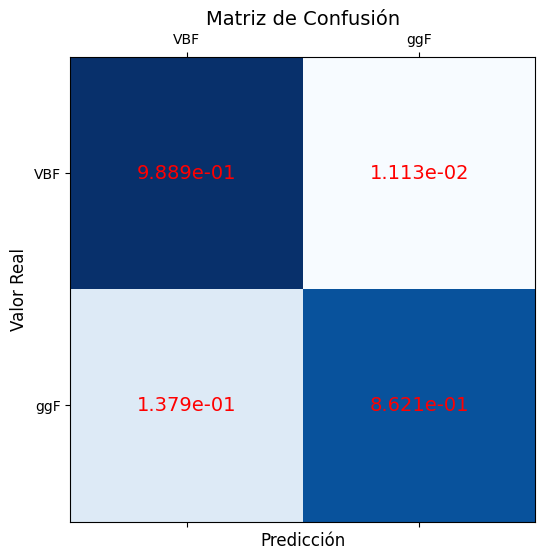

In [12]:
plot_matriz(matriz, porcentaje = True, normalizado=True)

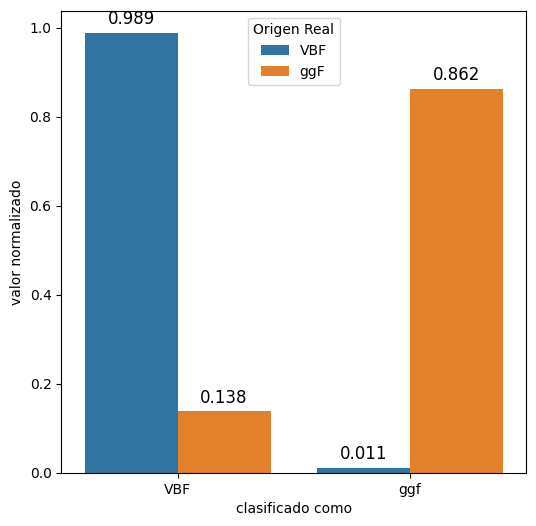

In [13]:
plot_confusion_barras(matriz)

In [14]:
# Encontrar mejor modelo
# best_model = find_best_model(X_train, y_train, X_test, y_test, X_val, y_val)